In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import concat_ws
from pyspark.sql import functions as F

In [2]:
# spark = SparkSession.builder.appName("drug-to_target_biodata").getOrCreate()
spark = SparkSession.builder \
    .appName("drug-to_target_biodata_3") \
    .config("spark.jars", "https://storage.googleapis.com/hadoop-lib/gcs/gcs-connector-hadoop3-latest.jar") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/30 12:29:38 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Data preparation for analysis

### Biodata only

In [14]:
# Testset with all biodata
biodata_all_in = "./data/drug2target_bioactivities_chembl_33.csv"

biodata_all = spark.read.csv(biodata_all_in, header=True, inferSchema=True)
biodata_all = biodata_all.drop('_c0')

# Filter rows where there is pChEMBL
biodata_all = biodata_all.filter(biodata_all['pchembl_value'] != 0)
biodata_all.show()

biodata_all_count = biodata_all.count()
print("Number of all drug-target pairs with pChEMBL:", biodata_all_count)

+----------+--------+---------------+------+--------------+--------------------+-----------+--------------------+-----+---------+--------------------+----------------+------------+--------------+--------------+-----------------+-------------+
| chembl_id|molregno|assay_chembl_id|src_id|src_short_name|             journal|  pubmed_id|                 doi|  tid|accession|           pref_name|target_chembl_id|    organism|standard_value|standard_units|standard_relation|pchembl_value|
+----------+--------+---------------+------+--------------+--------------------+-----------+--------------------+-----+---------+--------------------+----------------+------------+--------------+--------------+-----------------+-------------+
|CHEMBL1000|  111185|   CHEMBL954102|     1|    LITERATURE|     Bioorg Med Chem|1.8448342E7|10.1016/j.bmc.200...|  165|   Q12809|                HERG|       CHEMBL240|Homo sapiens|      30199.52|            nM|                =|         4.52|
|CHEMBL1000|  111185|  CHEMB

In [15]:
# Apply min activity value for each drug-target pair
from pyspark.sql import Window
from pyspark.sql.functions import row_number, concat_ws

# Define window specification
windowSpec = Window.partitionBy("chembl_id", "target_chembl_id").orderBy(biodata_all["pchembl_value"].desc())

# Assign row number
biodata_all_sort = biodata_all.withColumn("row_num", row_number().over(windowSpec))

# Filter to keep only rows with maximum pchembl_value for each chembl_id within each target_chembl_id
biodata_all_min = biodata_all_sort.filter(biodata_all_sort.row_num == 1).drop("row_num")

biodata_all_min.show()

print("Number of unique drug-target pairs with pChEMBL min:", biodata_all_min.count())

+------------+--------+---------------+------+--------------+--------------------+-----------+--------------------+------+---------+--------------------+----------------+------------+--------------+--------------+-----------------+-------------+
|   chembl_id|molregno|assay_chembl_id|src_id|src_short_name|             journal|  pubmed_id|                 doi|   tid|accession|           pref_name|target_chembl_id|    organism|standard_value|standard_units|standard_relation|pchembl_value|
+------------+--------+---------------+------+--------------+--------------------+-----------+--------------------+------+---------+--------------------+----------------+------------+--------------+--------------+-----------------+-------------+
|  CHEMBL1000|  111185|   CHEMBL830377|     1|    LITERATURE|Bioorg Med Chem Lett|1.5686917E7|10.1016/j.bmcl.20...|   127|   P35367|Histamine H1 rece...|       CHEMBL231|Homo sapiens|          5.89|            nM|                =|         8.23|
|  CHEMBL1000|  

In [8]:
# biodata_all_min.repartition(1).write.csv("data/analysis/biodata_all_min", header=True)

#### But we need to know for this testset if each target for a drug is therapeutic or not

In [3]:
evidence_path = "data/evidence/sourceId=chembl"
evidence = spark.read.parquet(evidence_path)

In [4]:
evidence.show(20)

23/10/30 12:29:52 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+------------+---------------+-------------+-------------------+--------+----------+----+---------------------------+---------------------------+---------------------------------+--------------------------------+-----------------+-------------+----------+--------------------+--------+-------------+---------------------+--------------------+-----------------+--------+----------------+---------------+----------+--------+-------------------+----------+----------------+--------------------+-------------------+-------------------------+-------------------------------------+-------------------------------------+--------------+-------------+------------+-----------------+----------+----------------------------+-------------------+--------------+---------+--------------------------------+--------------------------------+--------------+--------------+--------+------+---------+----------------------+---------------+----------+------------+-------------+----+------------------------+-------------

In [5]:
joined_df = biodata_all_min.join(
    evidence,
    (biodata_all_min.chembl_id == evidence.drugId) & 
    (biodata_all_min.target_chembl_id == evidence.targetFromSource),
    'left'
)

# Create isMoA column based on whether drugId is not null after the join
biodata_all_min_with_isMoA = joined_df.withColumn(
    "isMoA",
    F.when(F.col("drugId").isNotNull(), True).otherwise(False)
)

# Select only columns from biodata_all_min and the new isMoA column
final_biodata_all_min = biodata_all_min_with_isMoA.select(*biodata_all_min.columns, "isMoA").dropDuplicates(subset=biodata_all_min.columns)


final_biodata_all_min.show()
final_biodata_all_min.count()


NameError: name 'biodata_all_min' is not defined

#### After manual checking several pairs have MoA=False, but should be True

In [8]:
# Checking if these cases present in evidence

targetFromSource = "CHEMBL2508"
drugId = "CHEMBL3301610"

row_exists = evidence.filter((evidence['targetFromSource'] == targetFromSource) & (evidence['drugId'] == drugId)).count() > 0

if row_exists:
    print(True)
else:
    print(False)

True


In [84]:
# Lets use Drug parquet from platform (molecule)
# gsutil -m cp -r gs://open-targets-data-releases/23.09/output/etl/parquet/molecule

molecule_path = "data/molecule"
molecule = spark.read.parquet(molecule_path)
molecule.show(10)

+-------------+--------------------+--------------------+--------------+---------------+--------------------+-------------------+-------------------------+--------+----------------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|           id|     canonicalSmiles|            inchiKey|      drugType|blackBoxWarning|                name|yearOfFirstApproval|maximumClinicalTrialPhase|parentId|hasBeenWithdrawn|isApproved|          tradeNames|            synonyms|     crossReferences|      childChemblIds|      linkedDiseases|       linkedTargets|         description|
+-------------+--------------------+--------------------+--------------+---------------+--------------------+-------------------+-------------------------+--------+----------------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--

In [85]:
# Checking if MoA is unknown for a drug

given_id = 'CHEMBL207197'

# Filter the DataFrame for the given id and check if linkedTargets is null
result = molecule.filter(F.col('id') == given_id).select(F.col('linkedTargets').isNull().alias('is_linkedTargets_null')).collect()

# Check if the result has rows and the first row's is_linkedTargets_null column is True
if result and result[0].is_linkedTargets_null:
    print(True)
else:
    print(False)

False


In [86]:
# Explode molecule dataset with preserving unknown MoA

from pyspark.sql.functions import explode_outer, col

# Extract 'rows' from 'linkedTargets' and explode using explode_outer
molecule_exploded = molecule.withColumn("linkedTargets", explode_outer(col("linkedTargets.rows")))

molecule_exploded.show()


# Count the number of rows where the exploded linkedTargets is NULL
num_null_linkedTargets = molecule_exploded.filter(col("linkedTargets").isNull()).count()

print(f"Number of rows with linkedTargets = NULL after explosion: {num_null_linkedTargets}")


+-------------+--------------------+--------------------+--------------+---------------+--------------------+-------------------+-------------------------+--------+----------------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------+--------------------+
|           id|     canonicalSmiles|            inchiKey|      drugType|blackBoxWarning|                name|yearOfFirstApproval|maximumClinicalTrialPhase|parentId|hasBeenWithdrawn|isApproved|          tradeNames|            synonyms|     crossReferences|      childChemblIds|      linkedDiseases|  linkedTargets|         description|
+-------------+--------------------+--------------------+--------------+---------------+--------------------+-------------------+-------------------------+--------+----------------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------+-----------------

In [87]:
# biodata_all_min: from uniprot in "accession" to ensembl id 
targets_path = "data/targets"
targets = spark.read.parquet(targets_path)
targets.show(10)

+---------------+--------------+--------------+--------------------+--------------------+--------------------+--------------------+----------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----+--------------------+--------------------+--------------+--------------------+--------------------+--------------------+--------------------+
|             id|approvedSymbol|       biotype|       transcriptIds| canonicalTranscript|      canonicalExons|     genomicLocation|alternativeGenes|        approvedName|                  go|           hallmarks|            synonyms|      symbolSynonyms|        nameSynonyms|functionDescriptions|subcellularLocations|         targetClass|     obsoleteSymbols|       obsoleteNames|          constraint| tep|          proteinIds|             dbXrefs|chemic

In [88]:
# Just a check for format

from pyspark.sql.functions import first

# Retrieve the value from the first row and column named "proteinIds"
value = targets.select(first("proteinIds")).collect()[0][0]
print(value)

[Row(id='P14209', source='uniprot_swissprot'), Row(id='A0A096LP69', source='uniprot_trembl'), Row(id='A6NGF6', source='uniprot_trembl'), Row(id='A6NJT9', source='uniprot_trembl'), Row(id='A8MQT7', source='uniprot_trembl'), Row(id='A6NIW1', source='uniprot_obsolete'), Row(id='O00518', source='uniprot_obsolete'), Row(id='Q6ICV7', source='uniprot_obsolete')]


In [89]:
# Exploding all uniprot types

from pyspark.sql.functions import explode, col

# Explode the proteinIds column to 'uniprot'
targets_exploded = targets.withColumn("uniprot", explode(col("proteinIds")))

# Extract and rename 'id' from 'uniprot' to 'targetID'
targets_extracted = targets_exploded.withColumn("accession", col("uniprot.id"))

targets_extracted = targets_extracted.withColumnRenamed("id", "targetID")

targets_extracted.show(5)


+---------------+--------------+--------------+--------------------+--------------------+--------------------+--------------------+----------------+--------------------+--------------------+---------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------+--------------------+--------------------+--------------------+----+--------------------+--------------------+--------------+--------------------+--------------------+-----------------+--------------------+--------------------+----------+
|       targetID|approvedSymbol|       biotype|       transcriptIds| canonicalTranscript|      canonicalExons|     genomicLocation|alternativeGenes|        approvedName|                  go|hallmarks|            synonyms|      symbolSynonyms|        nameSynonyms|functionDescriptions|subcellularLocations|targetClass|     obsoleteSymbols|       obsoleteNames|          constraint| tep|          proteinIds|             dbXrefs|chemicalProbes|  

In [90]:
# Joining with ensembl id by uniprot 

biodata_all_ensembl = biodata_all_min.join(targets_extracted.select("accession", "targetID"), on="accession", how="left").drop(targets_extracted["accession"])

biodata_all_ensembl.show(10)

+---------+------------+--------+---------------+------+--------------+--------------------+-----------+--------------------+------+--------------------+----------------+------------+--------------+--------------+-----------------+-------------+---------------+
|accession|   chembl_id|molregno|assay_chembl_id|src_id|src_short_name|             journal|  pubmed_id|                 doi|   tid|           pref_name|target_chembl_id|    organism|standard_value|standard_units|standard_relation|pchembl_value|       targetID|
+---------+------------+--------+---------------+------+--------------+--------------------+-----------+--------------------+------+--------------------+----------------+------------+--------------+--------------+-----------------+-------------+---------------+
|   P35367|  CHEMBL1000|  111185|   CHEMBL830377|     1|    LITERATURE|Bioorg Med Chem Lett|1.5686917E7|10.1016/j.bmcl.20...|   127|Histamine H1 rece...|       CHEMBL231|Homo sapiens|          5.89|            nM| 

In [91]:
# Finding MoAs in molecule_exploded (id, linkedTargets)

joined_df = biodata_all_ensembl.join(
    molecule_exploded,
    (biodata_all_ensembl.chembl_id == molecule_exploded.id) & 
    (biodata_all_ensembl.targetID == molecule_exploded.linkedTargets),
    'left'
)

# Create isMoA column based on whether drugId (if) is not null after the join
biodata_all_with_isMoA = joined_df.withColumn(
    "isMoA",
    F.when(F.col("id").isNotNull(), True).otherwise(False)
)

# Create unknownMoA column based on whether linkedTargets is null
biodata_all_with_unknownMoA = biodata_all_with_isMoA.withColumn(
    "unknownMoA",
    F.when(F.col("linkedTargets").isNull(), True).otherwise(False)
)

# Select only columns from biodata_all_ensembl and the new isMoA & unknownMoA columns
final_biodata_all_min = biodata_all_with_unknownMoA.select(*biodata_all_ensembl.columns, "isMoA", "unknownMoA").dropDuplicates(subset=biodata_all_ensembl.columns)

final_biodata_all_min.show()
final_biodata_all_min.count()

+---------+------------+--------+---------------+------+--------------+--------------------+-----------+--------------------+------+--------------------+----------------+------------+--------------+--------------+-----------------+-------------+---------------+-----+----------+
|accession|   chembl_id|molregno|assay_chembl_id|src_id|src_short_name|             journal|  pubmed_id|                 doi|   tid|           pref_name|target_chembl_id|    organism|standard_value|standard_units|standard_relation|pchembl_value|       targetID|isMoA|unknownMoA|
+---------+------------+--------+---------------+------+--------------+--------------------+-----------+--------------------+------+--------------------+----------------+------------+--------------+--------------+-----------------+-------------+---------------+-----+----------+
|   P35367|  CHEMBL1000|  111185|   CHEMBL830377|     1|    LITERATURE|Bioorg Med Chem Lett|1.5686917E7|10.1016/j.bmcl.20...|   127|Histamine H1 rece...|       CHE

29698

### Biodata + GE

In [94]:
# Join biodata_all_min with GE+ dataset

drug2target_parquet_dir = "./data/drug_to_target"
drug2target_parquet = spark.read.parquet(drug2target_parquet_dir)

columns_to_join = drug2target_parquet.select('drugId', 'uniprotId', 'sources', 'isHighQualityProbe', 'isTherapeuticTarget')

biodata_all_join = final_biodata_all_min.join(columns_to_join, 
                            (final_biodata_all_min.chembl_id == columns_to_join.drugId) & 
                            (final_biodata_all_min.accession == columns_to_join.uniprotId), 
                            how="left")
biodata_all_join.show()
biodata_all_join.count()

# num_biodata_all_join = biodata_all_join.count()
# num_biodata_all_min = final_biodata_all_min.count()

# print("Number of unique drug-target pairs with GE+ with pChEMBL:", num_biodata_all_join)

# print("Number of unique drug-target pairs with pChEMBL", num_biodata_all_min)

# print("For", round(num_biodata_all_join/num_biodata_all_min*100), "% of drug-target pairs with pChEMBL we have GE+")

+---------+------------+--------+---------------+------+--------------+--------------------+-----------+--------------------+------+--------------------+----------------+------------+--------------+--------------+-----------------+-------------+---------------+-----+----------+------------+---------+--------------------+------------------+-------------------+
|accession|   chembl_id|molregno|assay_chembl_id|src_id|src_short_name|             journal|  pubmed_id|                 doi|   tid|           pref_name|target_chembl_id|    organism|standard_value|standard_units|standard_relation|pchembl_value|       targetID|isMoA|unknownMoA|      drugId|uniprotId|             sources|isHighQualityProbe|isTherapeuticTarget|
+---------+------------+--------+---------------+------+--------------+--------------------+-----------+--------------------+------+--------------------+----------------+------------+--------------+--------------+-----------------+-------------+---------------+-----+---------

29708

In [95]:
# Add column about activity using cutoff

from pyspark.sql.functions import when, col

protein_class_in = "./data/forPolina_uniprot2family.csv"

protein_class = spark.read.csv(protein_class_in, header=True, inferSchema=True)

biodata_all_join_class = biodata_all_join.join(protein_class, 
                            (biodata_all_join.accession == protein_class.accession), 
                            how="left").drop(protein_class.accession)

# Custom cutoff
biodata_all_join_class_active = biodata_all_join_class.withColumn(
    "isActive",
    when(
        ((col("proteinClass") == "Kinase") & (col("pchembl_value") >= 7.7)) |
        ((col("proteinClass") == "GPCR") & (col("pchembl_value") >= 6.5)) |
        ((col("proteinClass") == "NR") & (col("pchembl_value") >= 6.1)) |
        ((col("proteinClass") == "Transporter") & (col("pchembl_value") >= 6.1)) |
        ((col("proteinClass") == "Enzyme") & (col("pchembl_value") >= 5.2)) |
        ((col("proteinClass") == "IC") & (col("pchembl_value") >= 4.6)) |
        ((col("proteinClass") == "Other") & (col("pchembl_value") >= 6.3)) |
        (~(col("proteinClass").isin(["Kinase", "GPCR", "NR", "Transporter", "Enzyme", "IC", "Other"])) & (col("pchembl_value") >= 5)),
        "TRUE"
    ).otherwise("FALSE")
)
biodata_all_join_class_active.show()
biodata_all_join_class_active.count()

+---------+------------+--------+---------------+------+--------------+--------------------+-----------+--------------------+------+--------------------+----------------+------------+--------------+--------------+-----------------+-------------+---------------+-----+----------+------------+---------+--------------------+------------------+-------------------+------------+--------+
|accession|   chembl_id|molregno|assay_chembl_id|src_id|src_short_name|             journal|  pubmed_id|                 doi|   tid|           pref_name|target_chembl_id|    organism|standard_value|standard_units|standard_relation|pchembl_value|       targetID|isMoA|unknownMoA|      drugId|uniprotId|             sources|isHighQualityProbe|isTherapeuticTarget|proteinClass|isActive|
+---------+------------+--------+---------------+------+--------------+--------------------+-----------+--------------------+------+--------------------+----------------+------------+--------------+--------------+-----------------+-

29708

In [96]:
# for OR calculation
from pyspark.sql import functions as F
from scipy.stats import chi2_contingency
import numpy as np
from pyspark.sql.types import BooleanType

# Convert columns to boolean
biodata_all = biodata_all_join_class_active.withColumn("isMoA", biodata_all_join_class_active["isMoA"].cast("boolean"))
biodata_all = biodata_all_join_class_active.withColumn("isActive", biodata_all_join_class_active["isActive"].cast("boolean"))

# Define a UDF to check if the sources list matches the undesired values
def filter_sources(sources):
    # Define the undesired lists
    undesired_lists = [
        ['chembl'],
        ['chemicalProbes'],
        ['chembl', 'chemicalProbes'],
        ['chemicalProbes', 'chembl']
    ]
    
    # Check if sources is one of the undesired lists
    return sources not in undesired_lists

# Register the UDF for Spark
filter_sources_udf = F.udf(filter_sources, BooleanType())

# First, filter out the NULL sources
biodata_GE_plus = biodata_all.filter(F.col("sources").isNotNull())

# Now, filter out the undesired sources using the UDF
biodata_GE = biodata_GE_plus.filter(filter_sources_udf(F.col("sources")))


biodata_GE.show()
a = biodata_all.count()
b = biodata_GE_plus.count()
c = biodata_GE.count()

print(a, b, c)

+---------+-------------+--------+---------------+------+--------------+--------------------+-----------+--------------------+------+--------------------+----------------+------------+--------------+--------------+-----------------+-------------+---------------+-----+----------+-------------+---------+--------------------+------------------+-------------------+------------+--------+
|accession|    chembl_id|molregno|assay_chembl_id|src_id|src_short_name|             journal|  pubmed_id|                 doi|   tid|           pref_name|target_chembl_id|    organism|standard_value|standard_units|standard_relation|pchembl_value|       targetID|isMoA|unknownMoA|       drugId|uniprotId|             sources|isHighQualityProbe|isTherapeuticTarget|proteinClass|isActive|
+---------+-------------+--------+---------------+------+--------------+--------------------+-----------+--------------------+------+--------------------+----------------+------------+--------------+--------------+--------------

29708 17487 9142


In [72]:
biodata_all.write.parquet("data/analysis/biodata_all_v2")

AnalysisException: [PATH_ALREADY_EXISTS] Path file:/Users/polina/Documents/Bioactivity/bioactivity/data/analysis/biodata_all_v2 already exists. Set mode as "overwrite" to overwrite the existing path.

In [ ]:
biodata_GE_plus.write.parquet("data/analysis/biodata_GE_plus_v2")

23/10/30 14:13:54 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
23/10/30 14:14:14 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


In [ ]:
biodata_GE.write.parquet("data/analysis/biodata_GE_v2")

### OR calculation for GE+

In [46]:
from pyspark.sql import functions as F
from scipy.stats import fisher_exact
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.functions import concat_ws


In [47]:
spark = SparkSession.builder \
    .appName("drug-to_target_biodata_analysis") \
    .config("spark.jars", "https://storage.googleapis.com/hadoop-lib/gcs/gcs-connector-hadoop3-latest.jar") \
    .getOrCreate()

23/10/30 14:27:42 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [50]:
biodata_all = spark.read.parquet("data/analysis/biodata_all_v2")
biodata_GE = spark.read.parquet("data/analysis/biodata_GE_v2")
biodata_GE_plus = spark.read.parquet("data/analysis/biodata_GE_plus_v2")

In [51]:
# Create contingency table for biodata_all
contingency_table_all = (
    biodata_all
    .groupBy("isActive", "isMoA")
    .agg(F.count("*").alias("count"))
    .orderBy("isActive", "isMoA")
)

contingency_table_all.show()
contingency_table_all_list = contingency_table_all.collect()

+--------+-----+-----+
|isActive|isMoA|count|
+--------+-----+-----+
|   false|false|14123|
|   false| true|  426|
|    true|false|12439|
|    true| true| 2720|
+--------+-----+-----+



In [52]:
# Create contingency table for biodata_GE_plus
contingency_table_GE_plus = (
    biodata_GE_plus
    .groupBy("isActive", "isMoA")
    .agg(F.count("*").alias("count"))
    .orderBy("isActive", "isMoA")
)

contingency_table_GE_plus.show()
contingency_table_GE_plus_list = contingency_table_GE_plus.collect()

+--------+-----+-----+
|isActive|isMoA|count|
+--------+-----+-----+
|   false|false| 6714|
|   false| true|  425|
|    true|false| 7630|
|    true| true| 2718|
+--------+-----+-----+



In [53]:
# Create contingency table for biodata_GE
contingency_table_GE = (
    biodata_GE
    .groupBy("isActive", "isMoA")
    .agg(F.count("*").alias("count"))
    .orderBy("isActive", "isMoA")
)
contingency_table_GE.show()
contingency_table_GE_list = contingency_table_GE.collect()


+--------+-----+-----+
|isActive|isMoA|count|
+--------+-----+-----+
|   false|false| 4667|
|   false| true|  286|
|    true|false| 2493|
|    true| true| 1696|
+--------+-----+-----+



In [54]:
# Extract counts for Fisher's test
a = contingency_table_all_list[0]['count']  # isActive = False, isMoA = False
b = contingency_table_all_list[1]['count']  # isActive = False, isMoA = True
c = contingency_table_all_list[2]['count']  # isActive = True, isMoA = False
d = contingency_table_all_list[3]['count']  # isActive = True, isMoA = True

# Fisher's Exact Test
_, p_value_all = fisher_exact([[a, b], [c, d]])

# 3. Compute Odds Ratio and its Confidence Interval
or_ratio_all = (a * d) / (b * c)
or_lower_all = np.exp(np.log(or_ratio_all) - 1.96*np.sqrt(1/a + 1/b + 1/c + 1/d))
or_upper_all = np.exp(np.log(or_ratio_all) + 1.96*np.sqrt(1/a + 1/b + 1/c + 1/d))

print(f"Odds Ratio for all biodata: {or_ratio_all}")
print(f"95% CI: ({or_lower_all}, {or_upper_all})")
print(f"P-value: {p_value_all}")

Odds Ratio for all biodata: 7.249378846706199
95% CI: (6.527227620105087, 8.051426535394084)
P-value: 0.0


In [55]:
# Extract counts for Fisher's test
a = contingency_table_GE_list[0]['count']  # isActive = False, isMoA = False
b = contingency_table_GE_list[1]['count']  # isActive = False, isMoA = True
c = contingency_table_GE_list[2]['count']  # isActive = True, isMoA = False
d = contingency_table_GE_list[3]['count']  # isActive = True, isMoA = True

# Fisher's Exact Test
_, p_value_GE = fisher_exact([[a, b], [c, d]])

# 3. Compute Odds Ratio and its Confidence Interval
or_ratio_GE = (a * d) / (b * c)
or_lower_GE = np.exp(np.log(or_ratio_GE) - 1.96*np.sqrt(1/a + 1/b + 1/c + 1/d))
or_upper_GE = np.exp(np.log(or_ratio_GE) + 1.96*np.sqrt(1/a + 1/b + 1/c + 1/d))

print(f"Odds Ratio for biodata with GE: {or_ratio_GE}")
print(f"95% CI: ({or_lower_GE}, {or_upper_GE})")
print(f"P-value: {p_value_GE}")

Odds Ratio for biodata with GE: 11.101338292674033
95% CI: (9.705309587428294, 12.698174208479498)
P-value: 0.0


In [56]:
# Extract counts for Fisher's test
a = contingency_table_GE_plus_list[0]['count']  # isActive = False, isMoA = False
b = contingency_table_GE_plus_list[1]['count']  # isActive = False, isMoA = True
c = contingency_table_GE_plus_list[2]['count']  # isActive = True, isMoA = False
d = contingency_table_GE_plus_list[3]['count']  # isActive = True, isMoA = True

# Fisher's Exact Test
_, p_value_GE_plus = fisher_exact([[a, b], [c, d]])

# 3. Compute Odds Ratio and its Confidence Interval
or_ratio_GE_plus = (a * d) / (b * c)
or_lower_GE_plus = np.exp(np.log(or_ratio_GE_plus) - 1.96*np.sqrt(1/a + 1/b + 1/c + 1/d))
or_upper_GE_plus = np.exp(np.log(or_ratio_GE_plus) + 1.96*np.sqrt(1/a + 1/b + 1/c + 1/d))

print(f"Odds Ratio for biodata with GE+: {or_ratio_GE_plus}")
print(f"95% CI: ({or_lower_GE_plus}, {or_upper_GE_plus})")
print(f"P-value: {p_value_GE_plus}")

Odds Ratio for biodata with GE+: 5.627523552540282
95% CI: (5.054608594928669, 6.265375595287316)
P-value: 1.8826845974391295e-291


In [57]:
import pandas as pd

# Convert Spark DataFrame to pandas DataFrame
df_GE_plus = contingency_table_GE_plus.toPandas()
df_GE = contingency_table_GE.toPandas()
df_all = contingency_table_all.toPandas()

# Add an identifier column
df_GE_plus['Table'] = 'GE_plus'
df_GE['Table'] = 'GE'
df_all['Table'] = 'all'

# Concatenate all DataFrames vertically
all_dfs = [df_GE_plus, df_GE, df_all]
combined_df = pd.concat(all_dfs, ignore_index=True)

print(combined_df)

combined_df.to_csv("data/analysis/contin_tables")


    isActive  isMoA  count    Table
0      False  False   6714  GE_plus
1      False   True    425  GE_plus
2       True  False   7630  GE_plus
3       True   True   2718  GE_plus
4      False  False   4667       GE
5      False   True    286       GE
6       True  False   2493       GE
7       True   True   1696       GE
8      False  False  14123      all
9      False   True    426      all
10      True  False  12439      all
11      True   True   2720      all


In [62]:
import matplotlib.pyplot as plt
import numpy as np

def forest_plot(ORs, CIs, p_values, labels):
    """
    Display a forest plot.
    
    Parameters:
    - ORs: List of odds ratios
    - CIs: List of confidence intervals (as tuples of (lower, upper))
    - p_values: List of p-values
    - labels: List of names for each OR/CI/p-value
    """
    y_pos = range(len(ORs), 0, -1)  # Position on the y axis

    plt.figure(figsize=(5, 4))
    plt.axvline(1, color='grey', linestyle='--')  # Line at OR=1

    for i, (or_val, (l, u), p_val) in enumerate(zip(ORs, CIs, p_values)):
        plt.plot([l, u], [y_pos[i]]*2, '-', color='black', linewidth=2)
        plt.plot(l, y_pos[i], marker='|', color='black', markersize=15, mew=2)
        plt.plot(u, y_pos[i], marker='|', color='black', markersize=15, mew=2)
        
# Display p-values
        if p_val < 0.001:
            plt.text(u + 0.3, y_pos[i], "p < 0.001", va='center', ha='left', fontsize=10)
        else:
            exponent = np.ceil(-np.log10(p_val)).astype(int)
            plt.text(u + 0.1, y_pos[i], f"p = $10^{{-{exponent}}}$", va='center', ha='left', fontsize=10)
        
        
        # Display OR and CI values above the intervals
        plt.text(or_val, y_pos[i] + 0.2, f"OR={or_val:.1f} ({l:.1f}, {u:.1f})", ha='center', va='bottom', fontsize=10)

    plt.yticks(y_pos, labels, fontsize=12)
    plt.xticks(range(2,16,4), range(2,16,4), fontsize=10)
    plt.xlim(2,16)
    plt.xlabel('Odds Ratio and 95% CI', fontsize=10)
    plt.tight_layout()
    # plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.ylim(0.5, len(ORs) + 0.5)
    plt.savefig("data/analysis/ORs_v1", dpi = 300)
    plt.show()
    

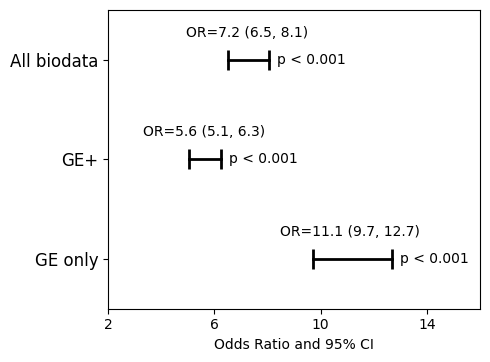

In [63]:
# Sample data
ORs = [or_ratio_all, or_ratio_GE_plus, or_ratio_GE]
CIs = [(or_lower_all, or_upper_all), (or_lower_GE_plus, or_upper_GE_plus), (or_lower_GE, or_upper_GE)]
p_values = [p_value_all, p_value_GE_plus, p_value_GE]
labels = ['All biodata', 'GE+', 'GE only']

forest_plot(ORs, CIs, p_values, labels)

In [73]:
from pyspark.sql.functions import col

biodata_GE_df = biodata_GE.withColumn("sources", col("sources").cast("string"))

In [74]:
biodata_GE_df.repartition(1).write.mode("overwrite").csv("data/biodata_GE_v3_csv", header=True)

### OR calculation for GE only (without probes and chembl evidence)

In [9]:
# Create 2x2 contingency table
table = (
    filtered_df.groupBy("isTherapeuticTarget")
    .pivot("isActive")
    .count()
    .fillna(0)
    .collect()
)

a = table[0][2]  # isTherapeuticTarget=True, isActive=True
b = table[0][1]  # isTherapeuticTarget=True, isActive=False
c = table[1][2]  # isTherapeuticTarget=False, isActive=True
d = table[1][1]  # isTherapeuticTarget=False, isActive=False

AA_rate = round(a/(a+c)*100)
II_rate = round(b/(d+b)*100)

# Print Contingency Table
print("Contingency Table:")
print("                    isActive=True  isActive=False")
print(f"isTherapeuticTarget=True   {a}             {b}")
print(f"isTherapeuticTarget=False  {c}             {d}")
print("")

# Calculate Odds Ratio
OR = (a * d) / (b * c) if b*c != 0 else np.inf  # To avoid division by zero

# Calculate 95% CI for OR
lower_limit = OR * np.exp(-1.96 * np.sqrt(1/a + 1/b + 1/c + 1/d))
upper_limit = OR * np.exp(1.96 * np.sqrt(1/a + 1/b + 1/c + 1/d))

# Calculate p-value using chi-squared test
_, p, _, _ = chi2_contingency([[a, b], [c, d]])

# Interpret the results
if p < 0.05:
    if OR > 1:
        print(f"The drug has significantly greater odds of being more active for therapeutic target (OR={OR:.3f}, 95% CI=({lower_limit:.3f}, {upper_limit:.3f}), p={p:.3e}).")
    else:
        print(f"The drug has significantly lower odds of being more active for therapeutic target (OR={OR:.3f}, 95% CI=({lower_limit:.3f}, {upper_limit:.3f}), p={p:.3e}).")
else:
    print(f"No significant association between drug's activity and  therapeutic target modulation (OR={OR:.3f}, 95% CI=({lower_limit:.3f}, {upper_limit:.3f}), p={p:.3e}).")

print(str(AA_rate) + "% of active drugs modulate therapeutic targets")
print(str(II_rate) + "% of non-active drugs modulate therapeutic targets")

Contingency Table:
                    isActive=True  isActive=False
isTherapeuticTarget=True   3359             2957
isTherapeuticTarget=False  824             1996

The drug has significantly greater odds of being more active for therapeutic target (OR=2.752, 95% CI=(2.502, 3.026), p=7.161e-100).
80% of active drugs modulate therapeutic targets
60% of non-active drugs modulate therapeutic targets


### ROC curve, log regression, biodata + GE+

In [21]:
from pyspark.ml.feature import VectorAssembler

# Convert columns to features and label format
assembler = VectorAssembler(inputCols=["pchembl_value"], outputCol="features")
df_copy = assembler.transform(df)

# Convert boolean to numeric
df_copy = df_copy.withColumn("label", df_copy["isTherapeuticTarget"].cast("double"))

In [26]:
df_copy[["features"]].show()

+--------+
|features|
+--------+
|  [5.16]|
|  [6.05]|
|  [5.15]|
|  [7.46]|
|  [5.09]|
|   [4.8]|
|  [5.89]|
|  [9.68]|
|  [4.46]|
|  [4.08]|
|  [6.34]|
|  [8.92]|
|  [7.04]|
|  [7.62]|
|   [8.1]|
|  [7.31]|
|  [9.02]|
|  [9.22]|
|  [6.36]|
|   [5.4]|
+--------+
only showing top 20 rows



23/10/16 22:07:47 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 933982 ms exceeds timeout 120000 ms
23/10/16 22:07:47 WARN SparkContext: Killing executors is not supported by current scheduler.
23/10/16 22:07:51 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1223)
	at o

In [12]:
# Split the data into training and testing sets

train_data, test_data = df_copy.randomSplit([0.8, 0.2])

In [13]:
from pyspark.ml.classification import LogisticRegression

# Define the logistic regression model
lr = LogisticRegression()

# Train the model
lr_model = lr.fit(train_data)

23/10/16 20:46:10 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/10/16 20:46:10 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


In [14]:
predictions = lr_model.transform(test_data)

In [15]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Compute area under the ROC curve
evaluator = BinaryClassificationEvaluator(metricName="areaUnderROC")
roc_auc = evaluator.evaluate(predictions)
print(f"Area under ROC = {roc_auc}")

Area under ROC = 0.5835766716390789


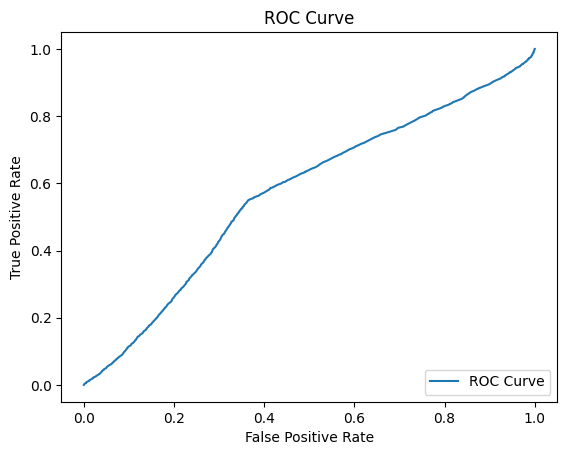

In [16]:
# To plot the ROC curve
roc = lr_model.summary.roc.toPandas()
import matplotlib.pyplot as plt

plt.plot(roc['FPR'], roc['TPR'], label='ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [80]:
# Try to make protein type as a feature, because of activity cutoffs

from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline

# Drop columns if they exist
if 'proteinClassIndex' in df.columns:
    df = df.drop('proteinClassIndex')

if 'proteinClassVec' in df.columns:
    df = df.drop('proteinClassVec')

# String Indexing
indexer = StringIndexer(inputCol="proteinClass", outputCol="proteinClassIndex")

# One-Hot Encoding
encoder = OneHotEncoder(inputCol="proteinClassIndex", outputCol="proteinClassVec")

# Vector Assembler
assembler = VectorAssembler(
    inputCols=["pchembl_value", "proteinClassVec"],
    outputCol="features"
)

# Set up the pipeline
pipeline = Pipeline(stages=[indexer, encoder, assembler])

# Transform the data
df_transformed = pipeline.fit(df).transform(df)


In [89]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import matplotlib.pyplot as plt

# Drop columns if they exist
if 'proteinClassIndex' in df.columns:
    df = df.drop('proteinClassIndex')
if 'proteinClassVec' in df.columns:
    df = df.drop('proteinClassVec')

# String Indexing
indexer = StringIndexer(inputCol="proteinClass", outputCol="proteinClassIndex")

# One-Hot Encoding
encoder = OneHotEncoder(inputCol="proteinClassIndex", outputCol="proteinClassVec")

# Vector Assembler
assembler = VectorAssembler(
    inputCols=["pchembl_value", "proteinClassVec"],
    outputCol="features"
)

# Set up the pipeline
pipeline = Pipeline(stages=[indexer, encoder, assembler])

# Transform the data
df_transformed = pipeline.fit(df).transform(df)

# Convert the target column to numeric (if it's boolean)
df_transformed = df_transformed.withColumn("label", df_transformed["isTherapeuticTarget"].cast("double"))

# Split the data
train_data, test_data = df_transformed.randomSplit([0.6, 0.4])

# Train the logistic regression model
lr = LogisticRegression()
lr_model = lr.fit(train_data)

# Make predictions on the test set
predictions = lr_model.transform(test_data)

Area under ROC = 0.690367119251465


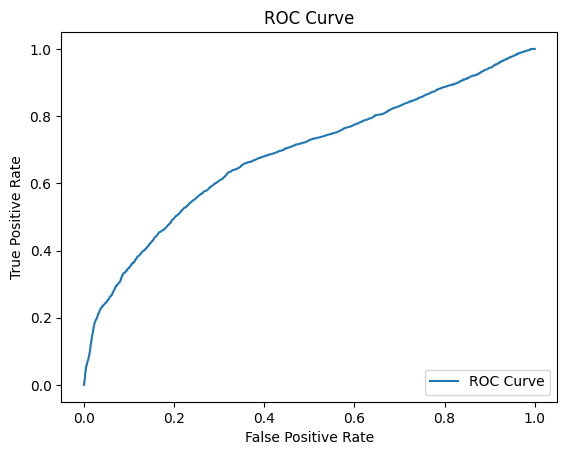

In [90]:
# Compute the AUC-ROC
evaluator = BinaryClassificationEvaluator(metricName="areaUnderROC")
roc_auc = evaluator.evaluate(predictions)
print(f"Area under ROC = {roc_auc}")

# Plot the ROC curve
roc = lr_model.summary.roc.toPandas()
plt.plot(roc['FPR'], roc['TPR'], label='ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (GE+)')
plt.legend(loc='lower right')
plt.show()

In [91]:
# Same but only for GE
# Define a UDF to check if the sources list matches the undesired values
def filter_sources(sources):
    # Define the undesired lists
    undesired_lists = [
        ['chembl'],
        ['chemicalProbes'],
        ['chembl', 'chemicalProbes'],
        ['chemicalProbes', 'chembl']
    ]
    
    # Check if sources is one of the undesired lists
    return sources not in undesired_lists

# Register the UDF for Spark
filter_sources_udf = F.udf(filter_sources, BooleanType())

# Filter the DataFrame
filtered_df = df.filter(filter_sources_udf(df['sources']))
filtered_df.show()
filtered_df.count()


+-------------+--------+---------------+------+--------------+--------------------+-----------+--------------------+------+---------+--------------------+----------------+------------+--------------+--------------+-----------------+-------------+-------------+---------+--------------------+------------------+-------------------+---------+------------+--------+
|    chembl_id|molregno|assay_chembl_id|src_id|src_short_name|             journal|  pubmed_id|                 doi|   tid|accession|           pref_name|target_chembl_id|    organism|standard_value|standard_units|standard_relation|pchembl_value|       drugId|uniprotId|             sources|isHighQualityProbe|isTherapeuticTarget|accession|proteinClass|isActive|
+-------------+--------+---------------+------+--------------+--------------------+-----------+--------------------+------+---------+--------------------+----------------+------------+--------------+--------------+-----------------+-------------+-------------+---------+----

9136

In [92]:
# String Indexing
indexer = StringIndexer(inputCol="proteinClass", outputCol="proteinClassIndex")

# One-Hot Encoding
encoder = OneHotEncoder(inputCol="proteinClassIndex", outputCol="proteinClassVec")

# Vector Assembler
assembler = VectorAssembler(
    inputCols=["pchembl_value", "proteinClassVec"],
    outputCol="features"
)

# Set up the pipeline
pipeline = Pipeline(stages=[indexer, encoder, assembler])

# Transform the data
df_transformed = pipeline.fit(filtered_df).transform(filtered_df)

# Convert the target column to numeric (if it's boolean)
df_transformed = df_transformed.withColumn("label", df_transformed["isTherapeuticTarget"].cast("double"))

# Split the data
train_data, test_data = df_transformed.randomSplit([0.7, 0.3])

# Train the logistic regression model
lr = LogisticRegression()
lr_model = lr.fit(train_data)

# Make predictions on the test set
predictions = lr_model.transform(test_data)

Area under ROC = 0.7521170247652198


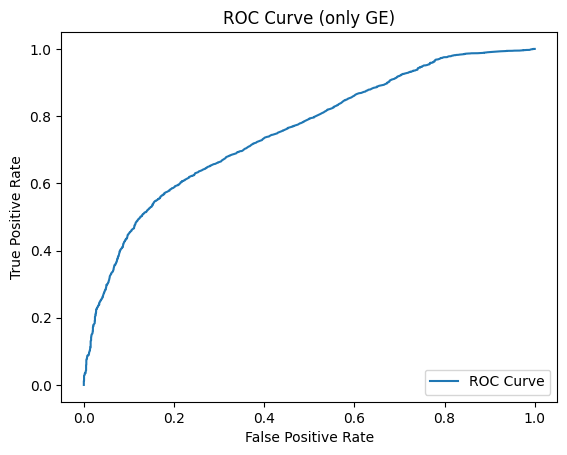

In [94]:
# Compute the AUC-ROC
evaluator = BinaryClassificationEvaluator(metricName="areaUnderROC")
roc_auc = evaluator.evaluate(predictions)
print(f"Area under ROC = {roc_auc}")

# Plot the ROC curve
roc = lr_model.summary.roc.toPandas()
plt.plot(roc['FPR'], roc['TPR'], label='ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (only GE)')
plt.legend(loc='lower right')
plt.show()

In [98]:
# So, if it's better for only GE, let's add source as a feature to previous one
# Rows containing only chembl or chemicalProbes or their combination are less valuable.
# Rows with more data sources in the list are more valuable.

In [114]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, CountVectorizer
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.functions import udf, size
from pyspark.sql.types import IntegerType

# Convert 'sources' from string to list if it's not already a list
if isinstance(df.select("sources").first()[0], str):
    from pyspark.sql.functions import split
    df = df.withColumn("sources", split(df["sources"], ","))

# Feature engineering: Create value_score based on sources
def compute_value_score(sources_list):
    less_valuable_sources = set(["chemicalProbes"])
    if set(sources_list).issubset(less_valuable_sources):
        base_score = 0
    else:
        base_score = 1
    score = base_score * len(sources_list)
    return score

value_score_udf = udf(compute_value_score, IntegerType())
df = df.withColumn("value_score", value_score_udf(df["sources"]))

# String Indexing for proteinClass
indexer = StringIndexer(inputCol="proteinClass", outputCol="proteinClassIndex")
df_indexed = indexer.fit(df).transform(df)

# One-Hot Encoding for proteinClass
encoder = OneHotEncoder(inputCol="proteinClassIndex", outputCol="proteinClassVec")
encoder_model = encoder.fit(df_indexed)
df_encoded = encoder_model.transform(df_indexed)

# Vector Assembler to assemble features into a single vector
assembler = VectorAssembler(
    inputCols=["pchembl_value", "proteinClassVec", "value_score"],
    outputCol="features"
)
df_transformed = assembler.transform(df_encoded)

# Convert the target column to numeric (if it's boolean)
df_transformed = df_transformed.withColumn("label", df_transformed["isTherapeuticTarget"].cast("double"))

# Split data into training and test sets
train_data, test_data = df_transformed.randomSplit([0.7, 0.3])

# Train the logistic regression model
lr = LogisticRegression()
lr_model = lr.fit(train_data)

# Make predictions on the test set
predictions = lr_model.transform(test_data)

# Evaluate model
evaluator = BinaryClassificationEvaluator(metricName="areaUnderROC")
roc_auc = evaluator.evaluate(predictions)
print(f"Area under ROC = {roc_auc}")


Area under ROC = 0.9089027143093105


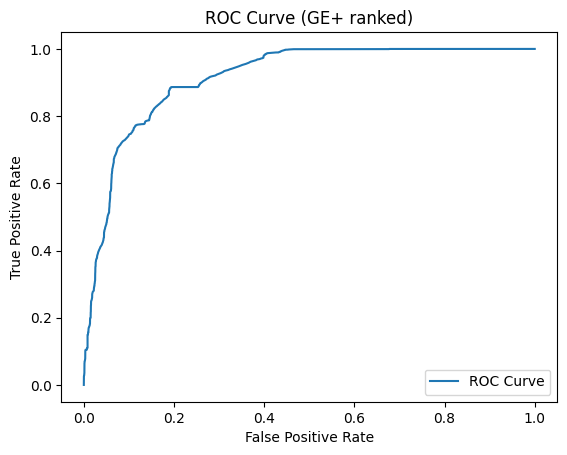

In [115]:
# Plot the ROC curve
roc = lr_model.summary.roc.toPandas()
plt.plot(roc['FPR'], roc['TPR'], label='ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (GE+ ranked)')
plt.legend(loc='lower right')
plt.show()

## Biodata from ChEMBL

In [10]:
# Testset with only min_standard_value
biodata_in = "./data/drug2target_bioactivities_chembl_33_grouped.csv"

biodata = spark.read.csv(biodata_in, header=True, inferSchema=True)
biodata = biodata.drop('_c0')
num_rows_biodata = biodata.count()
biodata.show()
print("Number of rows:", num_rows_biodata)

biodata_uni = (biodata.groupBy("chembl_id", "accession")
          .agg(F.count("*").alias("count_of_combinations")))
num_uni_rows_biodata = biodata_uni.count()
print("Number of unique drug-target pairs:", num_uni_rows_biodata)

+------------+--------+------+---------+--------------------+----------------+------------------+--------------+
|   chembl_id|molregno|   tid|accession|           pref_name|target_chembl_id|min_standard_value|standard_units|
+------------+--------+------+---------+--------------------+----------------+------------------+--------------+
|  CHEMBL1000|  111185|104067|   Q96FL8|Multidrug and tox...|   CHEMBL1743126|               2.0|             %|
|  CHEMBL1000|  111185| 17045|   P08684| Cytochrome P450 3A4|       CHEMBL340|              13.0|             %|
|  CHEMBL1000|  111185|   165|   Q12809|                HERG|       CHEMBL240|          30199.52|            nM|
|  CHEMBL1000|  111185|103947|   Q9Y6L6|Solute carrier or...|   CHEMBL1697668|              35.7|             %|
|  CHEMBL1000|  111185|   127|   P35367|Histamine H1 rece...|       CHEMBL231|              5.89|            nM|
|  CHEMBL1000|  111185| 12675|   P02763|Alpha-1-acid glyc...|      CHEMBL4285|              5.12

NameError: name 'F' is not defined

In [4]:
biodata_uni_t = biodata.dropDuplicates(["target_chembl_id"])
num_uni_t_biodata = biodata_uni_t.count()
print("Number of unique targets with biodata:", num_uni_t_biodata)

Number of unique targets with biodata: 2372


## Target-Drug pairs from OpenTargets (GE, CT, probes)

In [6]:
# gcloud storage rsync gs://ot-team/irene/drug_to_target data/drug_to_target

drug2target_parquet_dir = "./data/drug_to_target"
drug2target_parquet = spark.read.parquet(drug2target_parquet_dir)

drug2target_parquet.show()

num_rows_drug2target = drug2target_parquet.count()
print("Number of rows:", num_rows_drug2target)

+----------+---------+---------------+--------------------+------------------+-------------------+
|    drugId|uniprotId|       targetId|             sources|isHighQualityProbe|isTherapeuticTarget|
+----------+---------+---------------+--------------------+------------------+-------------------+
|CHEMBL1000|   O00167|ENSG00000064655|[ot_genetics_portal]|             false|              false|
|CHEMBL1000|   O00555|ENSG00000141837|[uniprot_literatu...|             false|              false|
|CHEMBL1000|   O14633|ENSG00000159455|[ot_genetics_portal]|             false|              false|
|CHEMBL1000|   O60706|ENSG00000069431|            [chembl]|             false|               true|
|CHEMBL1000|   P00352|ENSG00000165092|[ot_genetics_portal]|             false|              false|
|CHEMBL1000|   P01567|ENSG00000214042|            [chembl]|             false|               true|
|CHEMBL1000|   P04155|ENSG00000160182|[ot_genetics_portal]|             false|              false|
|CHEMBL100

In [7]:
# Remove rows that have duplicate drugId, targetId combinations
drug2target_uni = drug2target_parquet.dropDuplicates(["targetId"])
drug2target_uni.show()

num_rows_uni_drug2target = drug2target_uni.count()
print("Number of unique targets with GE+:", num_rows_uni_drug2target)

+-------------+---------+---------------+--------------------+------------------+-------------------+
|       drugId|uniprotId|       targetId|             sources|isHighQualityProbe|isTherapeuticTarget|
+-------------+---------+---------------+--------------------+------------------+-------------------+
|    CHEMBL423|   Q9NSG2|ENSG00000000460|[ot_genetics_portal]|             false|              false|
|CHEMBL1187417|   Q9Y6X5|ENSG00000001561|              [impc]|             false|              false|
|   CHEMBL6995|   Q9Y6D9|ENSG00000002822|[impc, ot_genetic...|             false|              false|
| CHEMBL193240|   Q9Y216|ENSG00000003987|[ot_genetics_portal]|             false|              false|
|CHEMBL1088752|   P52569|ENSG00000003989|              [impc]|             false|              false|
|CHEMBL2103959|   Q9Y2S7|ENSG00000004142|[impc, ot_genetic...|             false|              false|
|  CHEMBL77622|   Q96JG6|ENSG00000004766|[ot_genetics_portal]|             false| 

Number of unique targets with GE+: 16347


### Biodata and evidence data intersection

In [25]:
columns_to_join = drug2target_parquet.select('drugId', 'uniprotId', 'sources', 'isHighQualityProbe', 'isTherapeuticTarget')

biodata_join = biodata.join(columns_to_join, 
                            (biodata.chembl_id == columns_to_join.drugId) & 
                            (biodata.accession == columns_to_join.uniprotId), 
                            how="inner")

biodata_join.show()

biodata_join_uni = (biodata_join.groupBy("chembl_id", "accession")
          .agg(F.count("*").alias("count_of_combinations")))

num_uni_rows_biodata_join = biodata_join_uni.count()

print("Number of unique drug-target pairs with GE+ and bidata:", num_uni_rows_biodata_join)

print("Number of unique drug-target pairs with bidata:", num_uni_rows_biodata)

print("For", round(num_uni_rows_biodata_join/num_uni_rows_biodata*100), "% of drug-target pairs with with bidata we have GE+")

+-------------+--------+------+---------+--------------------+----------------+------------------+--------------+-------------+---------+--------------------+------------------+-------------------+
|    chembl_id|molregno|   tid|accession|           pref_name|target_chembl_id|min_standard_value|standard_units|       drugId|uniprotId|             sources|isHighQualityProbe|isTherapeuticTarget|
+-------------+--------+------+---------+--------------------+----------------+------------------+--------------+-------------+---------+--------------------+------------------+-------------------+
| CHEMBL103667|  167995| 11636|   P05771|Protein kinase C ...|      CHEMBL3045|            6900.0|            nM| CHEMBL103667|   P05771|[ot_genetics_port...|             false|               true|
|    CHEMBL104|   13494|   130|   P35462|Dopamine D3 receptor|       CHEMBL234|             899.0|            nM|    CHEMBL104|   P35462|[ot_genetics_port...|             false|               true|
|    CHEMB

Number of unique drug-target pairs with GE+ and bidata: 24880
Number of unique drug-target pairs with bidata: 53991
For 46 % of drug-target pairs with with bidata we have GE+


### For how many drugs from GE+ supported list of D-T pairs we have biodata?

In [39]:
drugs_uni = "./data/drug_to_target_unique_drugs.csv"

drugs_uni = spark.read.csv(drugs_uni, header=True, inferSchema=True)
num_rows_drugs_uni = drugs_uni.count()
print("Number of unique drugs from GE+ list:", num_rows_drugs_uni)

biodata_drugs_uni = (biodata_join.groupBy("chembl_id")
          .agg(F.count("*").alias("count_of_combinations")))
num_rows_drugs_uni_biodata = biodata_drugs_uni.count()
print("Number of unique drugs from biodata list:", num_rows_drugs_uni_biodata)

print("For", round(num_rows_drugs_uni_biodata/num_rows_drugs_uni*100), "% of drugs from GE+ list we have biodata")

Number of unique drugs from GE+ list: 12835


Number of unique drugs from biodata list: 6652
For 52 % of drugs from GE+ list we have biodata


### How many targets with GE+ and bioactivity data are not therapeutic targets (not in MoA)?

In [65]:
biodata_join_therapy = biodata_join.filter(biodata_join.isTherapeuticTarget == False)

biodata_join_targets_uni = (biodata_join.groupBy("target_chembl_id")
          .agg(F.count("*").alias("count_of_combinations")))
num_biodata_join_targets_uni = biodata_join_targets_uni.count()

print("Number of unique targets with GE+ & biodata:", num_biodata_join_targets_uni)

biodata_join_therapy_uni = (biodata_join_therapy.groupBy("target_chembl_id")
          .agg(F.count("*").alias("count_of_combinations")))
num_biodata_join_therapy_uni = biodata_join_therapy_uni.count()

print("Number of unique targets with GE+ & biodata & not therapeutic targets:", num_biodata_join_therapy_uni)

print(round(num_biodata_join_therapy_uni/num_biodata_join_targets_uni*100), "% of targets with GE+ & biodata are not therapeutic")

Number of unique targets with GE+ & biodata: 1839


Number of unique targets with GE+ & biodata & not therapeutic targets: 1422
77 % of targets with GE+ & biodata are not therapeutic


### Repeating the targets analysis with pChEMBL value cutoff (pChEMBL >= 5)

In [3]:
# Testset with all biodata
biodata_all_in = "./data/drug2target_bioactivities_chembl_33.csv"

biodata_all = spark.read.csv(biodata_all_in, header=True, inferSchema=True)
biodata_all = biodata_all.drop('_c0')

# Filter rows where pChEMBL is less than or equal to 5
biodata_all = biodata_all.filter(biodata_all['pchembl_value'] >= 5)
biodata_all.show()

biodata_all_count = biodata_all.count()
print("Number of all drug-target pairs with pChEMBL >= 5:", biodata_all_count)

# biodata_all.repartition(1).write.csv("data/biodata_all_join_test", header=True)


+----------+--------+---------------+------+--------------+--------------------+-----------+--------------------+---+---------+--------------------+----------------+------------+--------------+--------------+-----------------+-------------+
| chembl_id|molregno|assay_chembl_id|src_id|src_short_name|             journal|  pubmed_id|                 doi|tid|accession|           pref_name|target_chembl_id|    organism|standard_value|standard_units|standard_relation|pchembl_value|
+----------+--------+---------------+------+--------------+--------------------+-----------+--------------------+---+---------+--------------------+----------------+------------+--------------+--------------+-----------------+-------------+
|CHEMBL1000|  111185|   CHEMBL830377|     1|    LITERATURE|Bioorg Med Chem Lett|1.5686917E7|10.1016/j.bmcl.20...|127|   P35367|Histamine H1 rece...|       CHEMBL231|Homo sapiens|          5.89|            nM|                =|         8.23|
|CHEMBL1000|  111185|  CHEMBL1224926

In [4]:
# !!! Should apply min values but not random!!
from pyspark.sql import Window
from pyspark.sql.functions import row_number, concat_ws

# Define window specification
windowSpec = Window.partitionBy("chembl_id", "target_chembl_id").orderBy(biodata_all["pchembl_value"].desc())

# Assign row number
biodata_all_sort = biodata_all.withColumn("row_num", row_number().over(windowSpec))

# Filter to keep only rows with maximum pchembl_value for each chembl_id within each target_chembl_id
biodata_all_min = biodata_all_sort.filter(biodata_all_sort.row_num == 1).drop("row_num")


biodata_all_min.show()

print("Number of unique drug-target pairs with pChEMBL >= 5:", biodata_all_min.count())


# biodata_all_join_min = biodata_all_join_sort.withColumn("sources", concat_ws(",", biodata_all_join["sources"]))
# biodata_all_join_min.repartition(1).write.csv("data/biodata_all_join_test", header=True)


+------------+--------+---------------+------+--------------+--------------------+-----------+--------------------+------+---------+--------------------+----------------+------------+--------------+--------------+-----------------+-------------+
|   chembl_id|molregno|assay_chembl_id|src_id|src_short_name|             journal|  pubmed_id|                 doi|   tid|accession|           pref_name|target_chembl_id|    organism|standard_value|standard_units|standard_relation|pchembl_value|
+------------+--------+---------------+------+--------------+--------------------+-----------+--------------------+------+---------+--------------------+----------------+------------+--------------+--------------+-----------------+-------------+
|  CHEMBL1000|  111185|   CHEMBL830377|     1|    LITERATURE|Bioorg Med Chem Lett|1.5686917E7|10.1016/j.bmcl.20...|   127|   P35367|Histamine H1 rece...|       CHEMBL231|Homo sapiens|          5.89|            nM|                =|         8.23|
| CHEMBL10041|  

In [5]:
drug2target_parquet_dir = "./data/drug_to_target"
drug2target_parquet = spark.read.parquet(drug2target_parquet_dir)

columns_to_join = drug2target_parquet.select('drugId', 'uniprotId', 'sources', 'isHighQualityProbe', 'isTherapeuticTarget')

biodata_all_join = biodata_all_min.join(columns_to_join, 
                            (biodata_all_min.chembl_id == columns_to_join.drugId) & 
                            (biodata_all_min.accession == columns_to_join.uniprotId), 
                            how="inner")
biodata_all_join.show()

num_biodata_all_join = biodata_all_join.count()
num_biodata_all_min = biodata_all_min.count()

print("Number of unique drug-target pairs with GE+ with pChEMBL >= 5:", num_biodata_all_join)

print("Number of unique drug-target pairs with pChEMBL >= 5:", num_biodata_all_min)

print("For", round(num_biodata_all_join/num_biodata_all_min*100), "% of drug-target pairs with pChEMBL >= 5 we have GE+")

+-------------+--------+---------------+------+--------------+--------------------+-----------+--------------------+------+---------+--------------------+----------------+------------+--------------+--------------+-----------------+-------------+-------------+---------+--------------------+------------------+-------------------+
|    chembl_id|molregno|assay_chembl_id|src_id|src_short_name|             journal|  pubmed_id|                 doi|   tid|accession|           pref_name|target_chembl_id|    organism|standard_value|standard_units|standard_relation|pchembl_value|       drugId|uniprotId|             sources|isHighQualityProbe|isTherapeuticTarget|
+-------------+--------+---------------+------+--------------+--------------------+-----------+--------------------+------+---------+--------------------+----------------+------------+--------------+--------------+-----------------+-------------+-------------+---------+--------------------+------------------+-------------------+
| CHEMB

Number of unique drug-target pairs with GE+ with pChEMBL >= 5: 16138
Number of unique drug-target pairs with pChEMBL >= 5: 26698
For 60 % of drug-target pairs with pChEMBL >= 5 we have GE+


In [6]:
biodata_all_join_save = biodata_all_join.withColumn("sources", concat_ws(",", biodata_all_join["sources"]))
biodata_all_join_save.repartition(1).write.mode("overwrite").csv("data/biodata_all_join_test", header=True)

In [7]:
biodata_all_join_targets = biodata_all_join.groupBy("target_chembl_id")
num_biodata_all_join_targets = biodata_all_join_targets.count().count()

print("Number of unique targets with GE+ & pChEMBL >= 5:", num_biodata_all_join_targets)

Number of unique targets with GE+ & pChEMBL >= 5: 1488


In [8]:
biodata_all_join_therapy = biodata_all_join.filter(biodata_all_join.isTherapeuticTarget == False)

biodata_all_join_therapy_uni = biodata_all_join_therapy.groupBy("target_chembl_id").count()
num_biodata_all_join_therapy_uni = biodata_all_join_therapy_uni.count()

print("Number of unique targets with GE+ & pChEMBL >= 5 & not therapeutic targets:", num_biodata_all_join_therapy_uni)

print(round(num_biodata_all_join_therapy_uni/num_biodata_all_join_targets*100), "% of targets with GE+ & pChEMBL >= 5 are not therapeutic")

Number of unique targets with GE+ & pChEMBL >= 5 & not therapeutic targets: 1090
73 % of targets with GE+ & pChEMBL >= 5 are not therapeutic


In [9]:
columns_to_aggregate = [
    "chembl_id", "molregno", "assay_chembl_id", "src_id", "src_short_name", 
    "journal", "pubmed_id", "doi", "tid", "accession", "pref_name", 
    "organism", "standard_value", "standard_units", "standard_relation", "pchembl_value",
    "isHighQualityProbe", "isTherapeuticTarget"
]

# Create aggregation expressions for unique values for standard columns
aggregations = [F.concat_ws(",", F.collect_set(col)).alias(f"{col}") for col in columns_to_aggregate]

# Handle the "sources" column specifically
sources_aggregation = F.concat_ws(",", F.flatten(F.collect_set("sources"))).alias("concatenated_sources")

# Add the sources aggregation to the list
aggregations.append(sources_aggregation)

# Group by 'target_chembl_id' and aggregate
grouped_data = biodata_all_join.groupBy("target_chembl_id").agg(*aggregations)

# Save to CSV
grouped_data.repartition(1).write.mode("overwrite").csv("data/biodata_all_join_v2", header=True)



In [10]:
grouped_data.count()

1488

### Protein classification

In [11]:
biodata_all_join.show()

+-------------+--------+---------------+------+--------------+--------------------+-----------+--------------------+------+---------+--------------------+----------------+------------+--------------+--------------+-----------------+-------------+-------------+---------+--------------------+------------------+-------------------+
|    chembl_id|molregno|assay_chembl_id|src_id|src_short_name|             journal|  pubmed_id|                 doi|   tid|accession|           pref_name|target_chembl_id|    organism|standard_value|standard_units|standard_relation|pchembl_value|       drugId|uniprotId|             sources|isHighQualityProbe|isTherapeuticTarget|
+-------------+--------+---------------+------+--------------+--------------------+-----------+--------------------+------+---------+--------------------+----------------+------------+--------------+--------------+-----------------+-------------+-------------+---------+--------------------+------------------+-------------------+
| CHEMB

In [12]:
protein_class_in = "./data/forPolina_uniprot2family.csv"

protein_class = spark.read.csv(protein_class_in, header=True, inferSchema=True)

protein_class.show()

+---------+------------+
|accession|proteinClass|
+---------+------------+
|   P32929|      Enzyme|
|   A4D0Y5|        None|
|   Q49A92|        None|
|   Q9UFW8|        None|
|   Q96K31|        None|
|   O14646|  Epigenetic|
|   Q8IWX8|        None|
|   Q99653|        None|
|   O94983|          TF|
|   Q8NA66|        None|
|   Q96M20|        None|
|   Q86VU5|      Enzyme|
|   P42695|        None|
|   Q8IYT2|      Enzyme|
|   Q9NSA3|        None|
|   Q96KP4|      Enzyme|
|   Q13956|      Enzyme|
|   O95476|      Enzyme|
|   Q9BYD5|        None|
|   Q969H4|      Enzyme|
+---------+------------+
only showing top 20 rows



In [13]:
biodata_all_join_class = biodata_all_join.join(protein_class, 
                            (biodata_all_join.accession == protein_class.accession), 
                            how="left")
biodata_all_join_class.show()
biodata_all_join_class.count()

+-------------+--------+---------------+------+--------------+--------------------+-----------+--------------------+------+---------+--------------------+----------------+------------+--------------+--------------+-----------------+-------------+-------------+---------+--------------------+------------------+-------------------+---------+------------+
|    chembl_id|molregno|assay_chembl_id|src_id|src_short_name|             journal|  pubmed_id|                 doi|   tid|accession|           pref_name|target_chembl_id|    organism|standard_value|standard_units|standard_relation|pchembl_value|       drugId|uniprotId|             sources|isHighQualityProbe|isTherapeuticTarget|accession|proteinClass|
+-------------+--------+---------------+------+--------------+--------------------+-----------+--------------------+------+---------+--------------------+----------------+------------+--------------+--------------+-----------------+-------------+-------------+---------+--------------------+-

16138

### Calculate targets by datasources with custom cutoff

In [14]:
# Custom cutoff
biodata_all_join_class_filter = biodata_all_join_class.filter(
    ((F.col("proteinClass") == "Kinase") & (F.col("pchembl_value") >= 7.7)) |
    ((F.col("proteinClass") == "GPCR") & (F.col("pchembl_value") >= 6.5)) |
    ((F.col("proteinClass") == "NR") & (F.col("pchembl_value") >= 6.1)) |
    ((F.col("proteinClass") == "Transporter") & (F.col("pchembl_value") >= 6.1)) |
    ((F.col("proteinClass") == "Enzyme") & (F.col("pchembl_value") >= 5.2)) |
    ((F.col("proteinClass") == "IC") & (F.col("pchembl_value") >= 4.6)) |
    ((F.col("proteinClass") == "Other") & (F.col("pchembl_value") >= 6.3)) |
    (~(F.col("proteinClass").isin(["Kinase", "GPCR", "NR", "Transporter", "Enzyme", "IC", "Other"])) & (F.col("pchembl_value") >= 5))
)
biodata_all_join_class_filter.show()
biodata_all_join_class_filter.count()

+-------------+--------+---------------+------+---------------+--------------------+-----------+--------------------+------+---------+--------------------+----------------+------------+--------------+--------------+-----------------+-------------+-------------+---------+--------------------+------------------+-------------------+---------+------------+
|    chembl_id|molregno|assay_chembl_id|src_id| src_short_name|             journal|  pubmed_id|                 doi|   tid|accession|           pref_name|target_chembl_id|    organism|standard_value|standard_units|standard_relation|pchembl_value|       drugId|uniprotId|             sources|isHighQualityProbe|isTherapeuticTarget|accession|proteinClass|
+-------------+--------+---------------+------+---------------+--------------------+-----------+--------------------+------+---------+--------------------+----------------+------------+--------------+--------------+-----------------+-------------+-------------+---------+-------------------

10246

In [15]:
custom_cutoff_targets = biodata_all_join_class_filter.groupBy("target_chembl_id")
num_custom_cutoff_targets = custom_cutoff_targets.count().count()

print("Number of unique targets with GE+ & pChEMBL cutoff:", num_custom_cutoff_targets)

Number of unique targets with GE+ & pChEMBL cutoff: 1339


In [17]:
custom_cutoff_therapy = biodata_all_join_class_filter.filter(biodata_all_join.isTherapeuticTarget == False)

custom_cutoff_therapy_uni = custom_cutoff_therapy.groupBy("target_chembl_id").count()
num_custom_cutoff_therapy_uni = custom_cutoff_therapy_uni.count()

print("Number of unique targets with GE+ & cutoff & not therapeutic targets:", num_custom_cutoff_therapy_uni)

print(round(num_custom_cutoff_therapy_uni/num_custom_cutoff_targets*100), "% of targets with GE+ & cutoff are not therapeutic")

Number of unique targets with GE+ & cutoff & not therapeutic targets: 939
70 % of targets with GE+ & cutoff are not therapeutic


In [1]:
columns_to_aggregate = [
    "chembl_id", "molregno", "assay_chembl_id", "src_id", "src_short_name", 
    "journal", "pubmed_id", "doi", "tid", "uniprotId", "pref_name", 
    "organism", "standard_value", "standard_units", "standard_relation", "pchembl_value",
    "isHighQualityProbe", "isTherapeuticTarget", "proteinClass"
]

# Create aggregation expressions for unique values for standard columns
aggregations = [F.concat_ws(",", F.collect_set(col)).alias(f"{col}") for col in columns_to_aggregate]

# Handle the "sources" column specifically
sources_aggregation = F.concat_ws(",", F.flatten(F.collect_set("sources"))).alias("concatenated_sources")

# Add the sources aggregation to the list
aggregations.append(sources_aggregation)

# Group by 'target_chembl_id' and aggregate
custom_cutoff_grouped_data = biodata_all_join_class_filter.groupBy("target_chembl_id").agg(*aggregations)

# Save to CSV
custom_cutoff_grouped_data.repartition(1).write.mode("overwrite").csv("data/biodata_all_join_v3", header=True)


NameError: name 'F' is not defined

In [19]:
from pyspark.sql.functions import udf, split
custom_cutoff_grouped_data = custom_cutoff_grouped_data.withColumn("concatenated_sources", split(custom_cutoff_grouped_data["concatenated_sources"], ","))

In [20]:
pdf = custom_cutoff_grouped_data.toPandas()


In [21]:
pdf["concatenated_sources_rem"] = pdf["concatenated_sources"].apply({lambda x: set(x) - set(["chembl", "chemicalProbes"])})

In [26]:
pdf["concatenated_sources_rem"].apply({lambda x: len(x) > 0}).sum()

<lambda>    896
dtype: int64

23/10/10 18:10:45 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 1097261 ms exceeds timeout 120000 ms
23/10/10 18:10:45 WARN SparkContext: Killing executors is not supported by current scheduler.
23/10/10 18:10:48 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$

In [23]:
pdf[pdf["concatenated_sources_rem"].apply({lambda x: len(x) > 0}).values]

,target_chembl_id,chembl_id,molregno,assay_chembl_id,src_id,src_short_name,journal,pubmed_id,doi,tid,...,organism,standard_value,standard_units,standard_relation,pchembl_value,isHighQualityProbe,isTherapeuticTarget,proteinClass,concatenated_sources,concatenated_sources_rem
0,CHEMBL1075094,"CHEMBL116438,CHEMBL165,CHEMBL48802,CHEMBL1762621","1139916,75869,103658,190171","CHEMBL3879610,CHEMBL4307109,CHEMBL3295141,CHEM...",1,LITERATURE,"ACS Med Chem Lett,Bioorg Med Chem,J Med Chem,J...","2.812644E7,2.4920381E7,2.8753294E7,3.1312409E7","10.1016/j.bmc.2017.01.005,10.1021/acs.jnatprod...",103144,...,Homo sapiens,"580.0,9900.0,5400.0,60.0",nM,=,"5.0,5.27,7.22,6.24",false,true,TF,"[impc, intogen, chembl, eva_somatic, cancer_ge...","{cancer_gene_census, intogen, eva_somatic, impc}"
1,CHEMBL1075167,"CHEMBL1336,CHEMBL1230609","692959,276734","CHEMBL1244865,CHEMBL1908417",1,LITERATURE,"Blood,Nat Biotechnol","1.9654408E7,2.2037378E7","10.1038/nbt.1990,10.1182/blood-2009-05-222034",103106,...,Homo sapiens,"0.51,2.7",nM,=,"8.57,9.29",false,false,Kinase,[impc],{impc}
2,CHEMBL1075319,"CHEMBL207433,CHEMBL2443061,CHEMBL3577885,CHEMB...","1817707,349135,1589591,1946198,425650","CHEMBL5161310,CHEMBL3383300,CHEMBL5214521,CHEM...","1,65","LIT_EUBOPEN_CGL,LITERATURE","Bioorg Med Chem,Bioorg Med Chem Lett,Eur J Med...","2.5455182E7,2.408046E7,2.4055075E7,3.5263708E7","10.1016/j.bmc.2013.08.031,10.6019/CHEMBL521274...",103167,...,Homo sapiens,"8.3,13.8,3000.0,8.9,1600.0",nM,=,"5.52,8.08,5.8,7.86,8.05","false,true","false,true",IC,"[ot_genetics_portal, ot_genetics_portal, chemb...",{ot_genetics_portal}
3,CHEMBL1163106,CHEMBL384304,361203,CHEMBL1908722,1,LITERATURE,Nat Biotechnol,2.2037378E7,10.1038/nbt.1990,103435,...,Homo sapiens,11.0,nM,=,7.96,false,false,Kinase,[ot_genetics_portal],{ot_genetics_portal}
4,CHEMBL1163126,"CHEMBL384304,CHEMBL428690,CHEMBL445813","361203,511261,14366",CHEMBL1908787,1,LITERATURE,Nat Biotechnol,2.2037378E7,10.1038/nbt.1990,103455,...,Homo sapiens,"8.3,0.69,2.2",nM,=,"9.16,8.08,8.66",false,false,Kinase,[impc],{impc}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1332,CHEMBL6120,"CHEMBL3746329,CHEMBL388590,CHEMBL3707347,CHEMB...","2039318,2464877,2056491,374182","CHEMBL4731283,CHEMBL4015171,CHEMBL3853546",1,LITERATURE,"ACS Med Chem Lett,Bioorg Med Chem Lett,Medchem...","2.8351592E7,3.3062187E7","10.1039/C6MD00190D,10.1021/acsmedchemlett.0c00...",102767,...,Homo sapiens,"23.0,22.0,37.2,33.0",nM,=,"7.48,7.43,7.64,7.66",false,true,Transporter,"[ot_genetics_portal, gene_burden, chembl]","{gene_burden, ot_genetics_portal}"
1334,CHEMBL6149,CHEMBL1421,361469,CHEMBL4807589,38,PATENT,,,,102770,...,Homo sapiens,5.0,nM,=,8.3,false,false,Kinase,"[impc, ot_genetics_portal]","{ot_genetics_portal, impc}"
1335,CHEMBL6152,"CHEMBL531,CHEMBL972,CHEMBL374478,CHEMBL161,CHE...","2208,365189,96021,83724,4584,12494","CHEMBL4700553,CHEMBL4700552,CHEMBL4700572",1,LITERATURE,Eur J Med Chem,3.0743095E7,10.1016/j.ejmech.2019.01.045,102780,...,Homo sapiens,"7900.0,3000.0,270.0,530.0,7100.0",nM,=,"6.28,5.1,6.57,5.15,5.52",false,"false,true",None,"[impc, uniprot_literature, impc, eva, orphanet...","{eva, uniprot_variants, ot_genetics_portal, im..."
1337,CHEMBL6174,"CHEMBL6,CHEMBL118","18694,173",CHEMBL4722423,1,LITERATURE,Eur J Med Chem,3.174005E7,10.1016/j.ejmech.2019.111863,101472,...,Homo sapiens,"70.0,280.0",nM,=,"6.55,7.16",false,false,Enzyme,"[eva, orphanet, eva_somatic, eva, eva_somatic]","{orphanet, eva, eva_somatic}"


In [24]:
trusted_targets

,target_chembl_id,chembl_id,molregno,assay_chembl_id,src_id,src_short_name,journal,pubmed_id,doi,tid,...,organism,standard_value,standard_units,standard_relation,pchembl_value,isHighQualityProbe,isTherapeuticTarget,proteinClass,concatenated_sources,concatenated_sources_rem
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1334,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1335,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1336,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1337,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
